# Imports

In [1]:
import torch
from torch import nn

import math
from typing import Optional, Tuple, Union, List

In [2]:
import os, sys
import kagglehub
import polars as pl
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm

from pathlib import Path

В этом ноутбуке строится прототип класса u-net подобной модели для задачи вибрационной диагностики

Ключевая задача - рассмотреть реализации u-net для DDPM и перевести их под задачу вибрационной диагностики.
Причем сделано это может бть в разнх контекстах: 1D задача(сигнал или спектр), 2D задача(спектрограмма сигнала) + можно декодировать, а можно прогнозировать, также можно кластеризацию делать.


Архитектурная идея u-net состоит в построениии архитектури с bottleneck, у которой размерность входа и размерность вихода совпадают.

# Data

In [3]:
DATA_PATH = "../data/2nd_test/"

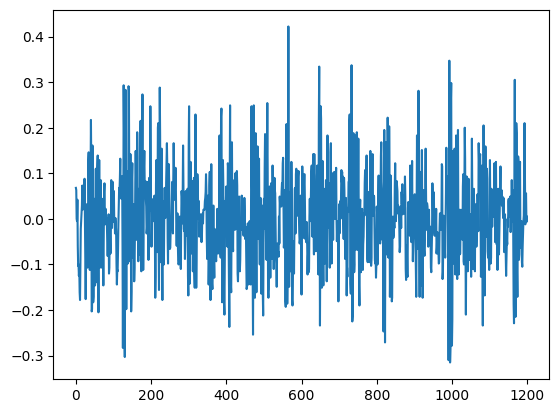

In [4]:
files = sorted(os.listdir(DATA_PATH))
example_data = pl.read_csv(Path(DATA_PATH) / files[2 * len(files) // 3], has_header=False, separator="\t")

l = len(example_data)
np_data = np.array(example_data["column_1"])

plt.plot(np_data[:1200])

In [5]:
class NASAIMSDataset(Dataset):
    def __init__(self, file_list, window_size=2048, bearing_idx=0):
        """
        Args:
            file_list (list): Список путей к файлам снапшотов.
            window_size (int): Размер окна (гиперпараметр).
            bearing_idx (int): Индекс колонки подшипника (0-3 для NASA IMS Test 2).
        """
        # 1. Сортировка имен файлов для соблюдения временной последовательности
        self.file_paths = sorted(file_list)
        self.window_size = window_size
        self.bearing_idx = bearing_idx
        
        # 2. Определяем количество точек в одном снапшоте
        # Читаем первый файл, чтобы узнать его длину
        sample_df = pl.read_csv(self.file_paths[0], separator='\t', has_header=False)
        self.points_per_file = len(sample_df)
        
        # 3. Считаем, сколько целых окон влезает в один файл
        self.windows_per_file = self.points_per_file // self.window_size
        
        if self.windows_per_file == 0:
            raise ValueError(f"Window size {window_size} is larger than file length {self.points_per_file}")

    def __len__(self):
        # Общая длина датасета: кол-во файлов * кол-во окон в каждом
        return len(self.file_paths) * self.windows_per_file

    def __getitem__(self, idx):
        # 4. Находим индекс файла и индекс окна внутри этого файла
        file_idx = idx // self.windows_per_file
        window_in_file_idx = idx % self.windows_per_file
        
        start_pos = window_in_file_idx * self.window_size
        end_pos = start_pos + self.window_size
        
        # 5. Читаем данные через polars
        # Читаем только нужную колонку для экономии памяти
        # Файлы NASA IMS Test 2 разделены табуляцией
        df = pl.read_csv(
            self.file_paths[file_idx], 
            separator='\t', 
            has_header=False,
            new_columns=['b1', 'b2', 'b3', 'b4']
        )
        
        # Берем нужный подшипник и нужный срез
        signal = df.select(pl.col(df.columns[self.bearing_idx])).to_numpy().flatten()
        window = signal[start_pos:end_pos].astype(np.float32)
        
        # 6. Локальная нормализация окна (Z-score)
        mean = window.mean()
        std = window.std()
        
        # Защита от деления на ноль (если сигнал вдруг константный)
        if std == 0:
            std = 1.0
            
        window = (window - mean) / std
        
        # Возвращаем тензор (добавляем размерность канала для Conv1D: [1, window_size])
        return torch.tensor(window).unsqueeze(0)

In [6]:
train_files = [Path(DATA_PATH) / el for el in files[:200]]
dataset = NASAIMSDataset(train_files, window_size=2048, bearing_idx=0)

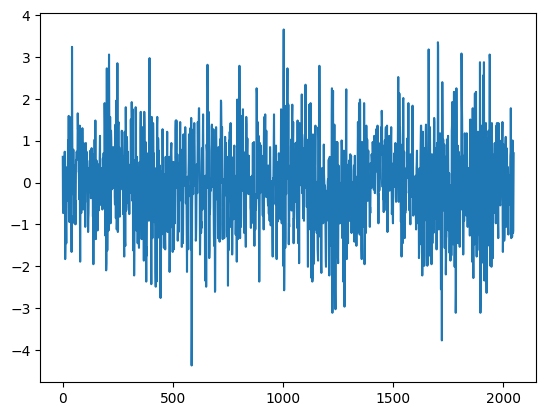

In [7]:
plt.plot(dataset[np.random.randint(len(dataset))].view(2048, -1))

# реализация UNet1D архиитектури

## Блок с остаточной связью

In [8]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_groups: int = 16,
                 dropout: float = 0.1, act_func: callable = nn.ReLU(), 
                 kernel_size: int = 3, padding: int = 1, dilation: int = 1,
                ):
        super().__init__()

        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.act1 = act_func

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.act2 = act_func

        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor):

        h = self.conv1(self.act1(self.norm1(x)))
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        return h + self.shortcut(x)

## Блок внимания

In [9]:
class AttentionBlock1D(nn.Module):
    def __init__(self, n_channels: int = 1, n_heads: int = 1, d_k: int = None, num_groups: int = 16):
        super().__init__()

        if d_k is None:
            d_k = n_channels

        self.norm = nn.GroupNorm(num_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)

        self.output = nn.Linear(n_heads * d_k, n_channels)

        self.scale = d_k ** -0.5

        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor):

        batch_size, n_channels, width = x.shape

        x = self.norm(x)

        x = x.permute(0, 2, 1)

        qkv = self.projection(x).view(batch_size, -1, self.n_heads, self.d_k * 3)
        q, k, v  = torch.chunk(qkv, 3, dim=-1)

        attn = torch.einsum("bihd,bjhd->bijh", q, k) * self.scale
        attn = attn.softmax(dim=2)

        res = torch.einsum("bijh,bjhd->bihd", attn, v)

        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res = res.permute(0, 2, 1).view(batch_size, n_channels, width)

        return res
        

## Блоки слева(без скипа) и справа(со скипом) от боттлнека на внимании и остаточной связи

In [10]:
class DownBlock1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, has_attn: bool):
        super().__init__()

        self.res = ResidualBlock1D(in_channels, out_channels)

        if has_attn:
            self.attn = AttentionBlock1D(out_channels)
        else:
            self.attn = nn.Identity()


    def forward(self, x: torch.Tensor):
        x = self.res(x)
        x = self.attn(x)
        return x

class UpBlock1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, has_attn: bool):
        super().__init__()

        self.res = ResidualBlock1D(in_channels + out_channels, out_channels)

        if has_attn:
            self.attn = AttentionBlock1D(out_channels)
        else:
            self.attn = nn.Identity()


    def forward(self, x: torch.Tensor):
        x = self.res(x)
        x = self.attn(x)
        return x

## Блок боттлнека

In [11]:
class MiddleBlock1D(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()

        self.res1 = ResidualBlock1D(n_channels, n_channels)
        self.res2 = ResidualBlock1D(n_channels, n_channels)
        self.attn = AttentionBlock1D(n_channels)


    def forward(self, x: torch.Tensor):
        x = self.res1(x)
        x = self.attn(x)
        x = self.res2(x)
        return x

## Блоки апсемплинга и даунсемплинга

In [12]:
class Downsample1D(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.conv = nn.Conv1d(n_channels, n_channels, 3, 2, 1)

    def forward(self, x: torch.Tensor):
        return self.conv(x)

class Upsample1D(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        self.conv = nn.Conv1d(n_channels, n_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor):
        x = self.upsample(x)
        return self.conv(x)

## Кульминация в виде Unet1D

In [39]:
class UNet1D(nn.Module):
    def __init__(self, entry_channels: int = 1, n_channels: int = 16,
                ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 4),
                is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, False),
                n_blocks: int = 2, act: callable = nn.ReLU()):
        super().__init__()

        self.entry_channels = entry_channels
        self.n_channels = n_channels
        self.ch_mults = ch_mults
        self.is_attn = is_attn
        self.n_blocks = n_blocks
        self.act = act
        
        n_resolutions = len(ch_mults)

        self.signal_proj = nn.Conv1d(entry_channels, n_channels, 3, padding=1)

        down = []
        out_channels = in_channels = n_channels

        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock1D(in_channels, out_channels, has_attn = is_attn[i]))
                in_channels = out_channels
                
            if i < n_resolutions - 1:
                down.append(Downsample1D(in_channels))

        self.down = nn.ModuleList(down)

        self.middle = MiddleBlock1D(out_channels)

        
        up = []
        in_channels = out_channels

        for i in reversed(range(n_resolutions)):
            out_channels = in_channels

            for _ in range(n_blocks):
                up.append(UpBlock1D(in_channels, out_channels, has_attn = is_attn[i]))

            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock1D(in_channels, out_channels, has_attn = is_attn[i]))
            in_channels = out_channels

            if i > 0:
                up.append(Upsample1D(in_channels))

        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = act
        self.final = nn.Conv1d(in_channels, entry_channels, 3, padding=1)

    def forward(self, x: torch.Tensor):
        x = self.signal_proj(x)
        h = [x]

        for m in self.down:
            x = m(x)
            h.append(x)

        x = self.middle(x)

        for m in self.up:
            if isinstance(m, Upsample1D):
                x = m(x)
            else:
                
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x)

        return self.final(self.act(self.norm(x)))

## Сохранение и загрузка модели

пример сохранения и загрузки:

```python
# --- Сохранение ---
meta = {"epoch": 42, "best_loss": 0.0015, "train_date": "2023-10-27"}
save_model_checkpoint(my_model, my_optimizer, "checkpoint.pth", metadata=meta)

# --- Загрузка в другом скрипте ---
# Нам НЕ НУЖНО знать, какие параметры были у UNet1D, они вытащатся из файла
model, metadata = load_model_checkpoint("checkpoint.pth")

print(f"Модель загружена! Эпоха из метаданных: {metadata['epoch']}")

# Не забываем перевести в режим оценки, если будем делать предсказания
model.eval()
```

In [41]:
def save_model_checkpoint(model: UNet1D, optimizer, path, metadata=None):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "model_params": {
            "entry_channels": model.entry_channels,
            "n_channels": model.n_channels,
            "ch_mults": model.ch_mults,
            "is_attn": model.is_attn,
            "n_blocks": model.n_blocks,
            "act": model.act 
        }
    }

    if metadata is not None:
        for k, v in metadata.items():
            if k not in checkpoint:
                checkpoint[k] = v

    torch.save(checkpoint, path)

def load_model_checkpoint(path, optimizer=None, device='cpu'):
    checkpoint = torch.load(path, map_location=device)
    model = UNet1D(**checkpoint['model_params'])

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    metadata = {k: v for k, v in checkpoint.items() if k not in 
                ['model_state_dict', 'optimizer_state_dict', 'model_params']}

    return model, metadata

# Снова автокодировщики

In [43]:
def ae_train_loop(ae_model, train_ds, test_ds, optimizer, epochs, device, batch_size, info_interval=5, path="..ae_checkpoints/", name="ae_model"):
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size) 
    val_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size)
    history = {"train_loss": [], "val_loss": []}
    
    criterion = nn.MSELoss()
    epoch_bar = tqdm(range(epochs), leave=False)
    for epoch in epoch_bar:
        epoch_bar.set_description()
        total_train_loss = 0
        total_val_loss = 0

        ae_model.train()
        train_bar = tqdm(train_loader, desc="Training")
        for batch in train_bar:
            data = batch.to(device)
            
            optimizer.zero_grad()
            
            rec_data = ae_model(data)

            loss =  criterion(rec_data, data)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_bar.set_postfix({"train_loss":loss.item()})
            
            
        ae_model.eval()
        val_bar = tqdm(val_loader, desc="Validation")
        for batch in val_bar:
            data = batch.to(device)
            
            rec_data = ae_model(data)
            loss =  criterion(rec_data, data)
            
            total_val_loss += loss.item()
            val_bar.set_postfix({"val_loss":loss.item()})
            
        epoch_bar.set_postfix({"train_loss" : total_train_loss / len(train_loader), "val_loss" : total_val_loss / len(val_loader)})
        history["train_loss"].append(total_train_loss / len(train_loader))
        history["val_loss"].append(total_val_loss / len(val_loader))
    
        if (epoch + 1) % info_interval == 0:
            metadata = {"epochs": epoch + 1}
            save_model_checkpoint(ae_model, optmizer, f"{path}/{name}_epoch{epoch + 1}.pth")

    save_model_checkpoint(ae_model, optmizer, f"{path}/{name}_epoch{epochs}.pth")

In [15]:
# number of files 
n_files = len(files)

# healthy data
healthy_th = 0.3
healthy_files = int(healthy_th * n_files)

test_th = 0.1
test_files = int(test_th * n_files)

window_size = 1024
bearing_idx = 0

train_files = [Path(DATA_PATH) / el for el in files[:healthy_files]]
test_files = [Path(DATA_PATH) / el for el in files[healthy_files:healthy_files + test_files]]

train_ds = NASAIMSDataset(train_files, window_size, bearing_idx)
test_ds = NASAIMSDataset(test_files, window_size, bearing_idx)

In [16]:
batch_size = 64
lr = 5e-4
epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"

unet_AE_1D = UNet1D().to(device)
optimizer = torch.optim.AdamW(unet_AE_1D.parameters(), lr=lr)

In [17]:
ae_train_loop(unet_AE_1D, train_ds, test_ds, optimizer, epochs, device, batch_size, info_interval=5)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
conv_bl = nn.Conv1d(1, 16, 3, padding=1)

a = torch.rand((1, 1, 2048))
b = conv_bl(a)
print(a.shape, b.shape)

In [ ]:
res_block = ResidualBlock1D(1, 16, 32)